# Cesium 2D+ MOT Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import random
from scipy.interpolate import interpn
from scipy.spatial import cKDTree

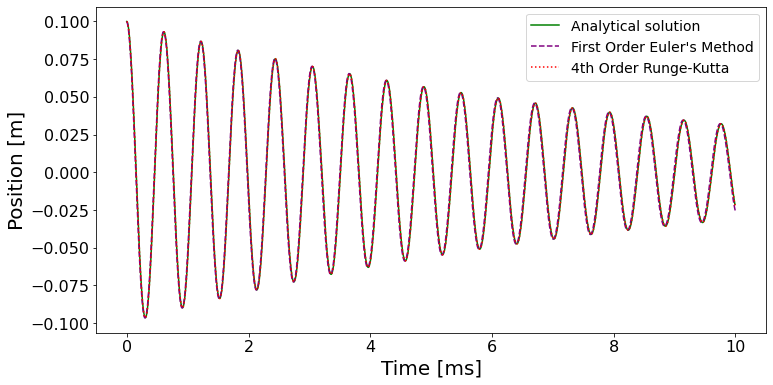

In [2]:
import nbimporter
%run DampedOscillator.ipynb

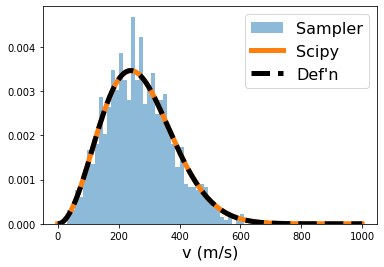

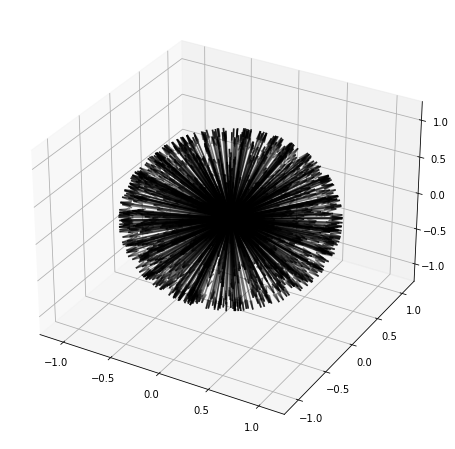

In [3]:
import nbimporter
%run MaxwellBoltzmann.ipynb

# Full 2D+ MOT Simulation

In [4]:
# Physical Constants
hbar = 1.055 * 10**(-34) # Js, reduced Planck's constant
light_c = 2.998 * 10**(8) # m/s
BohrMag = 9.27401008 * 10**(-24) # A m^2

# Cesium Specifics
mass = 2.20694695 * 10**(-25) # kg 
gamma = 5.22 * 10**(6) # Hz, natural line width of Cs D2 transition. Lam p. 86.
omega_D2 = 2*np.pi* 351.72571859 * 10**(12) # Hz. Steck p. 15: https://steck.us/alkalidata/cesiumnumbers.1.6.pdf

# Apparatus
tube_diam = 1.5 * 10**(-3) # meters, equal to 1.5mm, differential pumping tube diameter
tube_length = 20 * 10**(-3) # meters, equal to 20mm, differential pumping tube length
bgrad_x = 0.15 # T/m, equal to 12 G/cm.
bgrad_y = bgrad_x
bgrad_z = 0

# Cell dimensions. Will group.
x_len = 0.04 # m
y_len = 0.04 # m
z_len = 0.1  #m


# Beams
long_cooling_waist = 34 * 10**(-3) # m. Equal to 8mm. Will Group
short_cooling_waist = 8 * 10**(-3) # m. Equal to 8mm. Will Group.
push_waist = 2.2 * 10**(-3) # m. Equal to 2.2 mm. Circularly symmetric. Page 54 Szulc.

# Optimize
s0_cooling = 23 
s0_push = 20
det_x = -1.9*gamma 
det_y = -1.9*gamma  

det_push = -1.9*gamma
det_counter = -3.5*gamma

In [5]:
# Check F vs. v profile for this param set.
showProfile = False
if showProfile:
    varr = np.linspace(-40**1, 40**1, 10000)
    x = 0.000 # meters

    Bx = .001 * magpy.getB(quadcoil, observers=(x*1000,0,0))[0] #Tesla
    compare = bgrad_x * x
    print(Bx)
    print(compare)
    plus, minus = getDeltaPM(x, varr, det_x, Bx)

    force = radiativeHelper(plus, minus, det_x, s0_cooling)

    plt.plot(varr, force, label="s0", ls="--", c="k")
    plt.xlabel("v (m/s)")
    plt.ylabel("F (Newtons)")
    plt.legend()

## Implementation Info
#### Storage
Positions and velocities of particles are stored as a numpy array of length 3. All functions take in a parameter called axis which must specify "x", "y", or "z". 

#### Geometry
Cooling should occur in the xy plane. 

## Forces

The radiative force takes the form of the following with $e^{-2r^2/w^2}$ representing its Gaussian profile.
$$ \vec{F}_{\pm} =s_0 e^{-2r^2/w^2}\frac{\hbar \gamma/2}{1 + s_0e^{-2r^2/w^2} + (2\Delta_{\pm}/\gamma)^2}\cdot\frac{\omega_{D2} + 2\pi\delta}{c}\hat{k}_{\pm} $$
where for the x-axis, for example:
$$ \Delta_{\pm} = \delta \mp \frac{kv_x}{2\pi} \mp \text{sign}(x)\frac{|\tilde{\mu}B_x(x,y,z)|}{2\pi\hbar}$$
where $\tilde{\mu} = \frac{2}{3}\mu_B$ for the D2 line of Rb-87, and $B_x(x,y,z)$ is the magnetic field x-component at position (x,y,z).

## Functions for the computation of overall detunings and forces

In [6]:
# Overall detuning for counter-push beam.
def getDeltaPlus(x,v,det,Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3

    return Delta_plus

# Overall detuning for push beam.
def getDeltaMinus(x,v,det,Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3

    return Delta_minus

# Get the overall detunings for the push and counterpush beams.
def getDeltaPMpusher(x, v, det_push, det_counter, Bfieldcomp):
    return getDeltaPlus(x,v,det_push, Bfieldcomp), getDeltaMinus(x,v,det_counter, Bfieldcomp)

# Get the overlal detunings for the cooling beams.
def getDeltaPM(x, v, det, Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3
    return Delta_plus, Delta_minus

# Helper function for forceRadiative function.
def radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted):
    k = (omega_D2 + 2*np.pi*det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus - F_minus

# Helper function for forcePush function.
def pushHelper(Delta_plus, Delta_minus, det_push, det_counter, s_adjusted):
    kcounter = (omega_D2 + 2*np.pi*det_push)/(light_c) # counter push
    kpush =  (omega_D2 + 2*np.pi*det_counter)/(light_c) # push 
    F_plus = kpush * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2) #  push
    F_minus = kcounter * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2) # counterpush
    return F_plus, F_minus

# dets = [det_push, det_counter]
def forcePush(x0, v0, dets, Bfieldcomp, s_adj):
    det_push = dets[0]
    det_counter = dets[1]
    # Compute Delta_{pm}. No magnetic field in this direction.
    Delta_plus, Delta_minus = getDeltaPMpusher(x0, v0, det_push, det_counter, Bfieldcomp)
    # Compute Force 
    fplus, fminus = pushHelper(Delta_plus, Delta_minus, det_push, det_counter, s_adj)
    
    # Return push and counterpush
    #return fplus - fminus 
    
    # Return just push
    return fplus

def forceRad(x0, v0, det, Bfieldcomp, s_adj):    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, Bfieldcomp)
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adj)
    return force

## Simulation tools (defining a simulation step, RK4 algorithm, etc.)

In [7]:
# One step of 4th Order Runge-Kutte algorithm.
# Set interpolate to False if you want to do the computationally
# expensive task of evaluating B-field at exact particle positions.
# If interpolate is True: 
def RK4_step(force, xn, yn, zn, vn, axis, quadcoil, dt, m=mass, interpolate=True):
        # Initialize parameters
        det = np.NaN
        #bgrad = np.NaN  # No longer needed due to coils.
        exponent = np.NaN
        s0 = np.NaN
        Bfieldcomp = np.NaN
        
        # Position variable
        pn = -10e9 # initialize outside of the axis-determination if blocks.
        
        if axis == 0: # x-axis.
            # Adjustment exponent for s0 -> s0e^{-2exponent}:
            exponent = (yn/short_cooling_waist_y)**2 + (zn/long_cooling_waist)**2
            # I/I_{sat}
            s0 = s0_cooling 
            # Detuning for x:
            det = det_x 
            # Set variable to edit in this RK4 step.
            pn = xn
        elif axis == 1: # y-axis.
            exponent = (xn/short_cooling_waist_x)**2 + (zn/long_cooling_waist)**2
            s0 = s0_cooling
            det = det_y
            pn = yn
        elif axis == 2: # z-axis.
            exponent = (xn/push_waist)**2 + (yn/push_waist)**2
            s0 = s0_push
            det = [det_push, det_counter]
            pn = zn
            
        # Make s_adj with the waist:
        s_adj = s0 * np.exp(-2*exponent)
        
        if interpolate:
            # Use B-field grid. If interpolate is on, then quadcoil = [tree, Bfields]
            # calculated from buildBfieldGrid() function
            tree = quadcoil[0]
            Bfields = quadcoil[1]
            point = [xn * 10**3, yn * 10**3, zn * 10**3] # Be sure to convert positions to mm.
            Bfieldcomp = 0.001 * queryLUT(point, tree, Bfields, axis) # convert to Tesla from mT
        else:
            # Get the B-field from the quadcoil. 
            # It comes from magpy in mT, so multiply by 1/1000.
            Bfieldcomp = 0.001 * magpy.getB(quadcoil, observers=(xn* 10**3, yn * 10**3, zn * 10**3))[axis]
        
        # Turn gravity on in the -y direction.
        g = 9.8 # m/s^2
        gravOn = 0 # Default is 0, meaning gravity shouldn't be in the force.
        if axis == 1: # y-axis:
            gravOn = 1
        
        # Make an RK4 STEP.
        K1 = force(pn, vn, det, Bfieldcomp, s_adj)/m  - gravOn*g
        L1 = vn
        
        K2 = force(pn + dt*L1/2, vn + dt*K1/2, det, Bfieldcomp, s_adj)/m - gravOn*g
        L2 = vn + dt*K1/2
        
        K3 = force(pn + dt*L2/2, vn + dt*K2/2, det, Bfieldcomp, s_adj)/m - gravOn*g
        L3 = vn + dt*K2/2
        
        K4 = force(pn + dt*L3, vn + dt*K3, det, Bfieldcomp, s_adj)/m - gravOn*g
        L4 = vn + dt*K3
        
        # Update xn and vn.
        # If z > z_len/2, then atom is in the tube,
        # then x,y beams should do nothing.
        if zn > z_len/2 and axis < 2: # x: axis = 0, y: axis = 1, z: axis = 3.
            pn = pn + vn*dt
            vn = vn
        else:
            pn = pn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
            vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        return pn, vn, K1*m # return force for logging

# One step of the simulation of a particle's trajectory.
# Requires the use of RK4_Step for each direction.
def step(forceRad, forcePush, vec_x, vec_v, quadcoil, dt):
    # Unpack vec_x
    xn, yn, zn = vec_x
    # Unpack vec_v
    vxn, vyn, vzn = vec_v
    
    # Time-evolve
    # x-direction
    xn, vxn, force_x = RK4_step(forceRad, xn, yn, zn, vxn, axis=0, quadcoil=quadcoil, dt=dt)
    # y-direction
    yn, vyn, force_y = RK4_step(forceRad, xn, yn, zn, vyn, axis=1, quadcoil=quadcoil, dt=dt)
    # z-direction
    zn, vzn, force_z = RK4_step(forcePush, xn, yn, zn, vzn, axis=2, quadcoil=quadcoil, dt=dt)
    
    return np.array([xn, yn, zn]), np.array([vxn, vyn, vzn]), np.array([force_x, force_y, force_z])
    
# Simulate a particle's trajectory for a given amount of time.
# Initial position and velocity vectors: vec_x, vec_v
def simulate(vec_x, vec_v, quadcoil, dt=10 * 10**(-6), num_timesteps=1000000, m=mass):
    # Storage
    positions = []
    positions.append(np.copy(vec_x))
    velocities = []
    velocities.append(np.copy(vec_v))
    times = []
    times.append(0)
    forces = []
    
    # Flag for success. 1 =  True. 0 = False.
    success = 0 # Initialize to 0 if one wants onnly the atoms that reach science chamber.
                # Initialize to 1 if one wants atoms that did not collide with wall AND science chamber atoms
    
    for j in range(0, num_timesteps):
        vec_x, vec_v, vec_force = step(forceRad, forcePush, vec_x, vec_v, quadcoil, dt)    
        positions.append(np.copy(vec_x))
        velocities.append(np.copy(vec_v))
        times.append((j+1) * dt)
        forces.append(np.copy(vec_force))
        
        if aboveCell(vec_x):
            if checkTubeCollision(vec_x):
                success=0
                break
            else: # if in tube and no collision, check if reached science chamber.
                if reachedScienceChamber(vec_x):
                    success=1
                    break
                    
        elif checkCollision(vec_x): # If it's not in the tube, it checks for cell collision.
            success=0
            break
        
    return np.array(positions), np.array(velocities), np.array(times), np.array(forces), success

### Boundary checks (collisions, reach science chamber, reach 3DMOT volume etc.)

In [8]:
# Return true if science chamber z (z_len/2 + tube_length) is acquired
def reachedScienceChamber(vec_x):
    x, y, z = vec_x
    if z > ((z_len/2) + tube_length):
        return True

# Return true if its above the cell.
def aboveCell(vec_x):
    x, y, z = vec_x
    if z > z_len/2:
        return True

# Assumption is that it the atom is in the tube (above cell)
def checkTubeCollision(vec_x):
    x, y, z = vec_x
    # Check collision in tube:
    if np.sqrt(x**2 + y**2) > tube_diam/2:
        return True 

# Return true if collision within the cell.
def checkCollision(vec_x):
    x, y, z = vec_x
    # It's in the cell, check for collisions.
    if np.abs(x) > x_len/2 or np.abs(y) > y_len/2 or z < -z_len/2:
        return True
    else:
        return False

# Returns true if in 3D MOT volume

## Master Simulation Cell
Atoms have randomized initial positions and velocites in the cell.

In [9]:
def getRandomX():
    return np.array([np.random.uniform(-x_len/2, x_len/2),np.random.uniform(-y_len/2, y_len/2), np.random.uniform(-z_len/2, z_len/2) ])

In [3]:
###################
#  Start the sim  #
###################
def startSim(tree, Bfields, N_sim, verbose=False):
    #N_sim = 10000

    # Data storage
    pos_rec = []
    vel_rec = []
    times_rec = []
    forces_rec = []
    successes = 0
    success_index = []

    # Generate the B-field 
    #quadcoil = makeQuadCoil(winds = 10, dist = 50, diam = 100, curr = 300, width = 1, anti = -1)
    #tree, Bfields = buildBfieldGrid(quadcoil, grid_spacing = 2 * 10**(-4))


    # Loop to simulate N_sim trajectories
    print("Simulating the trajectories of", N_sim, "atoms...")
    start = time.time()
    for n in range(0, N_sim):
        # Sample a velocity vector from MBD
        smp = sampleVelocityVec()

        # Initialize atom
        vec_x = getRandomX()
        vec_v = np.array([smp[0], smp[1], smp[2]]) # Sampled v from Maxwell-Boltzmann

        # Simulate the atom's trajectory
        pos, vel, times, forces, success = simulate(vec_x, vec_v, [tree, Bfields], num_timesteps=1000000)

        # Save data.
        if success == 1:
            successes += 1
            success_index.append(n)
            print("Success at n = ", n)
            pos_rec.append(pos)
            vel_rec.append(vel)
            forces_rec.append(forces)
            times_rec.append(times)
        else:
            # Add empty lists to save memory. Just want to save successful trajectories now.
            pos_rec.append([])
            vel_rec.append([])
            forces_rec.append([])
            times_rec.append([])

        # Update user with progress
        if verbose:
            if n % int(N_sim/100) == 0:
                print("Done with run ", n, " | Total time elapsed =", 
                          round((time.time()-start)/60, 3), "minutes")

    print("Successful: ", successes)
    print("Success index: ", success_index)
    
    return pos_rec, vel_rec, times_rec, forces_rec, success_index, successes

### Looking at one science chamber atom's trajectory:

In [12]:
def printTrajectory(foldername, pos_rec, vel_rec, forces_rec, times_rec, index=0):
    fig, ax = plt.subplots(3, 3, figsize=(22, 12))

    sim = True
    if sim:
        nnn = success_index[index]
        pos = pos_rec[nnn]
        vel = vel_rec[nnn]
        forces = forces_rec[nnn]
        times = times_rec[nnn]

    # x-pos (TOP LEFT)
    ax[0,0].plot(times, pos[:, 0], label="RK4")
    ax[0,0].axhline(0, ls="--", c="black")
    ax[0,0].set_xlabel("t (sec)")
    ax[0,0].set_ylabel("x (m)", fontsize=16)

    # v_x (middle LEFT)
    ax[1,0].plot(times, vel[:, 0], label="RK4")
    ax[1,0].axhline(0, ls="--", c="black")
    ax[1,0].set_xlabel("t (sec)")
    ax[1,0].set_ylabel("v_x (m/s)", fontsize=16)

    # F_x (bottom LEFT)
    ax[2,0].plot(times[1:], forces[:, 0], label="RK4")
    ax[2,0].set_xlabel("t (sec)")
    ax[2,0].set_ylabel("F_x (N)", fontsize=16)

    # y-pos (TOP CENTER)
    ax[0, 1].plot(times, pos[:, 1], label="RK4")
    ax[0, 1].axhline(0, ls="--", c="black")
    ax[0, 1].set_xlabel("t (sec)")
    ax[0, 1].set_ylabel("y (m)", fontsize=16)

    # v_y (BOTTOM CENTER)
    ax[1, 1].plot(times, vel[:, 1], label="RK4")
    ax[1, 1].axhline(0, ls="--", c="black")
    ax[1, 1].set_xlabel("t (sec)")
    ax[1, 1].set_ylabel("v_y (m/s)", fontsize=16)

    # F_y (bottom middle)
    ax[2,1].plot(times[1:], forces[:, 1], label="RK4")
    ax[2,1].set_xlabel("t (sec)")
    ax[2,1].set_ylabel("F_y (N)", fontsize=16)


    # z-pos (TOP RIGHT)
    ax[0, 2].plot(times, pos[:, 2], label="RK4")
    ax[0, 2].set_xlabel("t (sec)")
    ax[0, 2].set_ylabel("z (m)", fontsize=16)

    # v_z (BOTTOM RIGHT)
    ax[1, 2].plot(times, vel[:, 2], label="RK4")
    ax[1, 2].axhline(0, ls="--", c="black")
    ax[1, 2].set_xlabel("t (sec)")
    ax[1, 2].set_ylabel("v_z (m/s)", fontsize=16)

    # F_z (bottom middle)
    ax[2,2].plot(times[1:], forces[:, 2], label="RK4")
    ax[2,2].set_xlabel("t (sec)")
    ax[2,2].set_ylabel("F_z (N)", fontsize=16)

    #plt.show()
    #plt.savefig(foldername+"/trajectorys/trajectory"+str(index)+".png", bbox_inches="tight")

    #printTrajectory("trash", pos_rec, vel_rec, forces_rec, times_rec)

### The initial and exit velocities of atoms that reach the science chamber

In [7]:
def printHistograms(foldername, vel_rec, success_index):
    # Make a histogram of the trapped speeds
    speeds = []
    vxs = []
    vys = []
    vzs = []

    # Exit
    espeeds = []
    evxs = [] 
    evys = []
    evzs = []

    for n in success_index:
        # Collect initial velocities
        vel = vel_rec[n][0]
        spd = np.sqrt(np.sum(vel**2))
        speeds.append(spd)
        vxs.append(vel[0])
        vys.append(vel[1])
        vzs.append(vel[2])

        # Collect exit velocities
        vel = vel_rec[n][-1]
        espd = np.sqrt(np.sum(vel**2))
        espeeds.append(espd)
        evxs.append(vel[0])
        evys.append(vel[1])
        evzs.append(vel[2])

    # Plotting:
    fig, ax = plt.subplots(2,4, figsize=(20,10))
    fig.suptitle("Initial and Exit Velocity Distributions for Successful Trajectories", fontsize=26)


    # Initial
    ax[0][0].hist(speeds, bins=30, label="speed", color="orange")
    ax[0][0].set_xlabel(r"Initial $|v|$ (m/s)", fontsize=16)

    ax[0][1].hist(vxs, bins=30, label="vx", color="orange")
    ax[0][1].set_xlabel(r"Initial $v_x$ (m/s)", fontsize=16)

    ax[0][2].hist(vys, bins=30, label="vy", color="orange")
    ax[0][2].set_xlabel(r"Initial $v_y$ (m/s)", fontsize=16)

    ax[0][3].hist(vzs, bins=30, label="vz", color="orange")
    ax[0][3].set_xlabel(r"Initial $v_z$ (m/s)", fontsize=16)

    # Exit
    ax[1][0].hist(espeeds, bins=30, label="speed", color="green")
    ax[1][0].set_xlabel(r"Exit $|v|$ (m/s)", fontsize=16)

    ax[1][1].hist(evxs, bins=30, label="vx", color="green")
    ax[1][1].set_xlabel(r"Exit $v_x$ (m/s)", fontsize=16)

    ax[1][2].hist(evys, bins=30, label="vy", color="green")
    ax[1][2].set_xlabel(r"Exit $v_y$ (m/s)", fontsize=16)

    ax[1][3].hist(evzs, bins=30, label="vz", color="green")
    ax[1][3].set_xlabel(r"Exit $v_z$ (m/s)", fontsize=16)
    
    plt.savefig(foldername+"/velocityhistograms.png", bbox_inches="tight", facecolor="white")

### Visualizing the trajectories of atoms that made it to the science chamber

In [9]:
#show3D = False
def print3D(foldername, pos_rec, success_index):
    fig = plt.figure(figsize=(20,40)) 
    ax = fig.add_subplot(211, projection='3d')
    ax.set_xlabel("x (m)", fontsize=16)
    ax.set_ylabel("y (m)", fontsize=16)
    ax.set_zlabel("z (m)", fontsize=16)
    ax.set_title("Full cell view", fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=12)

    show = True
    successfulOnly = True
    plotAll = True # otherwise plotN:
    plotN = 15
    if show:
        if successfulOnly:
            if plotAll:
                for n in success_index:
                    pos = pos_rec[n]
                    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
            else:
                for i in range(plotN):
                    pos = pos_rec[success_index[i]]
                    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
        else:
            for i in range(0, plotN):
                pos = pos_rec[random.randint(0, N_sim-1)]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    #  [95, 191, 316, 436, 478, 616, 987]
    sim = False
    if sim:
        nnn = success_index[0] # Plot this index
        pos = pos_rec[nnn]
        vel = vel_rec[nnn]
        forces = forces_rec[nnn]
        times = times_rec[nnn]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])


    # Build beams:
    showBeams = True
    if showBeams:
        alpha = 0.03
        # Cylinder | https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        xcyl = np.linspace(-push_waist, push_waist, 1000)
        zcyl = np.linspace(-z_len/2, tube_length + z_len/2, 1000)
        Xc, Zc = np.meshgrid(xcyl, zcyl)
        Yc = np.sqrt(push_waist**2-Xc**2)
        ax.plot_surface(Xc, Yc, Zc, alpha=alpha, color="blue")
        ax.plot_surface(Xc, -Yc, Zc, alpha=alpha, color="blue")

        xcyl = np.linspace(-short_cooling_waist_y, short_cooling_waist_y, 1000)
        ycyl = np.linspace(-y_len, y_len, 1000) 
        Xc, Yc = np.meshgrid(xcyl, ycyl)
        Zc = np.sqrt(long_cooling_waist**2 * (1 - Xc**2/short_cooling_waist_y**2))
        ax.plot_surface(Xc, Yc, Zc, alpha=alpha, color="blue")
        ax.plot_surface(Xc, Yc, -Zc, alpha=alpha, color="blue")

        ycyl = np.linspace(-short_cooling_waist_x, short_cooling_waist_x, 1000)
        xcyl = np.linspace(-x_len, x_len, 1000) 
        Xc, Yc = np.meshgrid(xcyl, ycyl)
        Zc = np.sqrt(long_cooling_waist**2 * (1 - Yc**2/short_cooling_waist_x**2))
        ax.plot_surface(Xc, Yc, Zc, alpha=alpha, color="blue")
        ax.plot_surface(Xc, Yc, -Zc, alpha=alpha, color="blue")

    # Build cell:
    showCell = True
    showTube = True

    if showCell:
        ls = "-"
        col="magenta"
        cell_x = np.linspace(-x_len/2, x_len/2, 1000)
        ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
        ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
        ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
        ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
        cell_y = np.linspace(-y_len/2, y_len/2, 1000)
        ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c=col,ls=ls)
        ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
        ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
        ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c=col,ls=ls)
        cell_z = np.linspace(-z_len/2, z_len/2, 1000)
        ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c=col, ls=ls)
        ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c=col,ls=ls)
        ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c=col, ls=ls)
        ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c=col, ls=ls)


        # Set limits for first plot
        limm = 0.5*z_len
        ax.set_xlim(-limm, limm)
        ax.set_ylim(-limm, limm)
        ax.set_zlim(-limm, limm)


    # Build hole
    if showTube:
        # Tube left fig
        uuu = np.linspace(0, 100, 10000)
        ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
        ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)

        ax = fig.add_subplot(2, 1, 2, projection='3d')
        # Plot:
        if show:
            if successfulOnly:
                if plotAll:
                    for n in success_index:
                        pos = pos_rec[n]
                        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
                else:
                    for i in range(plotN):
                        pos = pos_rec[success_index[i]]
                        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
            else:
                plotN = 10
                for i in range(0, plotN):
                    pos = pos_rec[random.randint(0, N_sim-1)]
                    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
        if sim:
            pos = pos_rec[nnn]
            vel = vel_rec[nnn]
            forces = forces_rec[nnn]
            times = times_rec[nnn]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

        # Tube right fig
        uuu = np.linspace(0, 100, 10000)
        ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
        ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)

        tubeCenter = False
        if tubeCenter:
            ax.set_xlim(-0.007*z_len, 0.007*z_len)
            ax.set_ylim(-0.007*z_len, 0.007*z_len)
            ax.set_zlim(-0.007*z_len, 0.007*z_len)

    ax.set_title("Escape tube view", fontsize=26)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")
    
    plt.savefig(foldername+"/3D.png", bbox_inches="tight", facecolor="white")

## Tracking through apparatus

In [14]:
# Distance of 3D MOT volume from tube:
MOT_tube_zrel = .55 #.55 # m, equal to 55cm.
captureRadius = .01 # m, equal to 1cm. This is the radius of the 3D MOT capture region.
captureVelocity = 40 # m/s

dt = 10 * 10**(-6) # s

def trackToChamber(MOT_tube_zrel, captureRadius, dt):
    # gravitational constant
    g = 9.8 # m/s^2
    captureCenter = np.array([0,0, MOT_tube_zrel]) # Origin is tube exit. This is the center of the 3D MOT.
    captures = 0
    positions_record = []
    capture_index = []

    for c, n in enumerate(success_index):
        print("Running #", c+1, "out of", len(success_index))
        n_pos = [] # Store positions of this atom
        # Get positions/velocities at tube-exit
        xn, yn, zn =  pos_rec[n][-1]
        vxn, vyn, vzn = vel_rec[n][-1]
        # While the atom hasn't yet passed the capture region:
        while zn < MOT_tube_zrel + 2*captureRadius:
            # Save position
            n_pos.append([xn, yn, zn])

            # Evolve the positions and the vy.
            vyn = vyn - g*(dt)        
            xn = xn + vxn*dt
            yn = yn + vyn*dt 
            zn = zn + vzn*dt 

            # Check if in capture radius
            if np.linalg.norm(np.array([xn, yn, zn]) - captureCenter) < captureRadius:
                # If it is in capture radius, check if its velocity is less/eq than the capture vel.
                if np.sqrt(vxn**2 + vyn**2 + vzn**2) <= captureVelocity:
                    captures +=1
                    capture_index.append(c)
                    n_pos.append([xn, yn, zn])
                    
                break   
       
        positions_record.append(n_pos)

    print("Captures:",captures)
    positions_record = np.array(positions_record)
    
    return captures, positions_record

In [6]:
showCapture = False
if showCapture:
    fig = plt.figure(figsize=(20,40)) 
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x (m)", fontsize=16)
    ax.set_ylabel("y (m)", fontsize=16)
    ax.set_zlabel("z (m)", fontsize=16)

    ax.set_xlim(-.01, .01)
    ax.set_ylim(-.01, .01)

    # Plot capture region for sphere: 
    ax.scatter(0, 0, MOT_tube_zrel, s=50)
    #ax.plot(np.zeroslike(), np.zeroslikes(), )

    print(positions_record.shape)

    for i in range(positions_record.shape[0]):
        pos = np.array(positions_record[i])
        c = "red"
        alpha = 0.4
        if i in capture_index:
            c = "green"
            alpha = 1.0

        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], c = c)

NameError: name 'plt' is not defined

In [ ]:
if showCapture:
    fig, ax = plt.subplots(2, figsize=(10,10)) 

    ax[0].set_xlabel("z (m)", fontsize=16)
    ax[0].set_ylabel("x (m)", fontsize=16)

    ax[1].set_xlabel("z (m)", fontsize=16)
    ax[1].set_ylabel("y (m)", fontsize=16)

    # Plot capture region for sphere: 
    #ax.scatter(0, 0, MOT_tube_zrel, s=50)

    z_arr = MOT_tube_zrel + np.linspace(-captureRadius, captureRadius, 10000)
    y_arr = np.sqrt(captureRadius**2 - (z_arr - MOT_tube_zrel)**2)
    ax[1].plot(z_arr, y_arr, "k--")
    ax[1].plot(z_arr, -y_arr, "k--")

    # Same usage for z,x
    ax[0].plot(z_arr, y_arr, "k--")
    ax[0].plot(z_arr, -y_arr, "k--")


    for i in range(positions_record.shape[0]):
        pos = np.array(positions_record[i])
        c = "red"
        alpha = 0.4
        if i in capture_index:
            c = "green"
            alpha = 1.0

        # z, x
        ax[0].plot(pos[:, 2], pos[:, 0], c = c)
        # z, y
        ax[1].plot(pos[:, 2], pos[:, 1], c = c)


## Import our B-field

In [64]:
#%run CoilCreator.ipynb

## B-field Interpolation (Computational speed-up)

In [67]:
import time

# Default grid spacing should be provided in meters.
def buildBfieldGrid(quadcoil, grid_spacing = 4 * 10**(-4)):
    # For timing information:
    start_time = time.time()
    
    # Remember that .getB takes observer positions in millimeters. 
    # Hence we make the grid in terms of mm.
    scf = 1000 # multiply the i_len's by this to put it in millimeters from meters

    # Tell user grid shape.
    print("B-field Grid shape: ", int(x_len/grid_spacing), "x", int(y_len/grid_spacing), "x", int(z_len/grid_spacing))
    
    # Generate grid points
    xgrid = np.linspace(-scf*x_len/2, scf*x_len/2, int(x_len/grid_spacing))
    ygrid = np.linspace(-scf*y_len/2, scf*y_len/2, int(y_len/grid_spacing))
    zgrid = np.linspace(-scf*z_len/2, scf*z_len/2, int(z_len/grid_spacing))
    gridpoints = (xgrid, ygrid, zgrid) # for interpolation function
    
    # Make data grid:
    tree_data = []
    array_of_gridpoints = []
    for idx, xx in enumerate(xgrid):
        for yy in ygrid:
            for zz in zgrid:
                gridpoint = (xx,yy,zz)
                # Add gridpoint to tree data in array form.
                tree_data.append(np.array([xx,yy,zz]))
                # Add tuple form to array_of_gridpoints. Will be used for .getB, which requires tuples.
                array_of_gridpoints.append((xx,yy,zz))
         
        # Timing information.
        if (idx+1)%10==0:
            print("Step", idx+1, "/", xgrid.shape[0], "done. | Total time elapsed =", 
                  round(time.time()-start_time, 3), "seconds")

    array_of_gridpoints = np.array(array_of_gridpoints)
    
    # .getB from the quadcoils:
    bfieldtime = time.time()
    print("magpylib is calculating B-field on the grid...")
    Bfields = magpy.getB(sources=quadcoil, observers=array_of_gridpoints)
    print("B-field calculated on the grid in", round((time.time()-bfieldtime)/60, 3), " minutes")

    # Create the kd-tree for nearest neighbors
    tree_data = np.array(tree_data)
    tree = cKDTree(tree_data)

    return tree, Bfields

# Provide a point and get the B-field for the gridpoint nearest to it.
# Point should have form [x,y,z]
def queryLUT(point, tree, Bfields, axis):
    # Find the 6 grid point (k=6) closest to the point we have:
    dists, indices = tree.query(point, k=6) # returns distance to nearest neighbor and index in tree_data.

    # Now output the magnetic field vector at that grid point. Recall that keys are tuples.
    field = Bfields[indices]
    axis_field = field[:, axis] # gives the component along the given axis.
    
    # Weighted averaged based on inverse distance
    weights = 1/dists**2
    avg_field = np.sum(weights * axis_field)/np.sum(weights)
    
    return avg_field

In [ ]:
#tree, Bfields = buildBfieldGrid(quadcoil)

In [ ]:
#point = [1,4,3]
#a = queryLUT(point, tree, Bfields, axis=0)
#a

In [ ]:
#10, 10**2, 10**3, 10**4, 10**5, 10**6 * a
#np.sum(a, axis=0)

In [68]:
#grid_spacing = 4 * 10**(-5)

#scf = 1000

# Tell user grid shape.
#print("B-field Grid shape: ", int(x_len/grid_spacing), "x", int(y_len/grid_spacing), "x", int(z_len/grid_spacing))

# Generate grid points
#xgrid = np.linspace(-scf*x_len/2, scf*x_len/2, int(x_len/grid_spacing))
#ygrid = np.linspace(-scf*y_len/2, scf*y_len/2, int(y_len/grid_spacing))
#zgrid = np.linspace(-scf*z_len/2, scf*z_len/2, int(z_len/grid_spacing))

# get stack
#Xg, Yg, Zg = np.meshgrid(xgrid, ygrid, zgrid)
#print("Done")

### Random scratch work.

In [ ]:
# Proof that pushHelper works.
#varr = np.linspace(-40, 40, 10000)
#x = 0
#s00 = s0

#plus, minus = getDeltaPMpusher(x, varr, det_push, det_counter, 0)

#fplus, fminus = pushHelper(plus, minus, det_push, det_counter, s00)

#plt.plot(varr, fplus, label="s0", ls="--", c="k")
#plt.xlabel("v (m/s)")
#plt.ylabel("F (Newtons)")
#plt.legend()

In [ ]:
# Checking my random vec_x generator works

vecs = []
for dummy in range(1000):
    vecs.append(getRandomX())
vecs = np.array(vecs)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Random points
ax.scatter(vecs[:,0], vecs[:,1], vecs[:,2])

# Cell
cell_x = np.linspace(-x_len/2, x_len/2, 1000)
ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
cell_y = np.linspace(-y_len/2, y_len/2, 1000)
ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
cell_z = np.linspace(-z_len/2, z_len/2, 1000)
ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")

plt.show()